In [ ]:
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import types
import json
import random
import time
import argparse
import pickle
import torch as T
import numpy as np
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict, namedtuple
root = '/content/drive/My Drive/dialog-data/'
#root = 'drive/dialog-data/'
sys.path.append(root)
import span_slot_data as D
!{sys.executable} -m pip install transformers==2.10
import transformers as tf

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 665kB 8.6MB/s 
     |████████████████████████████████| 1.1MB 22.9MB/s 
     |████████████████████████████████| 3.8MB 50.5MB/s 
     |████████████████████████████████| 890kB 47.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=2d08e951b217bfedb56427233f583d4b7e038ef4f923b579c322dafade1f00ed
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a5012363

In [ ]:
class Run:
    def __init__(self):
        self.records = defaultdict(list)
        
    def log(self, key, value):
        self.records[key].append(value)

def evaluate(start_logits, end_logits, start_positions, end_positions, attention_mask, **kwargs):
    with T.no_grad():
        seq_len = attention_mask.sum(-1).float()
        batch_size = start_logits.shape[0]
        strt_index, end_index = T.max(start_logits, dim=-1)[1], T.max(end_logits, dim=-1)[1]
        start_diff =  T.abs(strt_index - start_positions).float()/seq_len
        end_diff =  T.abs(end_index - end_positions).float()/seq_len
        correct_mask = (start_diff == 0) & (end_diff == 0)
        correct = T.where(correct_mask)[0].cpu().numpy()
        wrong = T.where(~correct_mask)[0].cpu().numpy()
        assert len(np.intersect1d(correct, wrong)) == 0
        strt_index, end_index = strt_index.cpu().numpy(), end_index.cpu().numpy()
        overall_acc = correct.shape[0]/batch_size
        start_acc = start_diff.mean().item()
        end_acc = end_diff.mean().item()
        return overall_acc, start_acc, end_acc, correct, wrong, strt_index, end_index

def print_example(tokenizer, batch, start_preds, end_preds, idx, correct):
    input_ids = batch['input_ids'][idx].cpu().numpy()
    def get_span(strt, end):
        if (strt == 0 and end == 0) or (strt > end):
            span = 'Not mentioned'
        else:
            span = input_ids[strt:end+1]
            span = ' '.join(tokenizer.convert_ids_to_tokens(span, skip_special_tokens=True))
        return span.replace(' ##', '')
    label_strt_idx = batch['start_positions'][idx].cpu().numpy()
    label_end_idx = batch['end_positions'][idx].cpu().numpy()
    state = ('Correct' if correct else 'Wrong')
    strt_idx, end_idx = start_preds[idx], end_preds[idx]
    print(' '.join(tokenizer.convert_ids_to_tokens(input_ids, True)).replace(' ##', ''))
    pred, label = get_span(strt_idx, end_idx), get_span(label_strt_idx, label_end_idx)
    print(f'Prediction: {pred}, Label: {label}\t {state}')

def train(model, optim, train_data, valid_data, no_batches, valid_duration=100,
          cuda=True, verbose=False, tokenizer=None, max_grad_norm=1.0,
          valid_size=1, run=None, batch_size=1, no_examples=10):
    if cuda:
        model = model.cuda()
    optim, scheduler = optim
    print("About to start training")
    start_time = time.time()
    valid_loss, valid_acc, valid_strt_dist, valid_end_dist, max_acc = 0, 0, 0, 0, 0
    print_gpu = False
    batch_size, total_batch_size = batch_size
    no_iter = total_batch_size//batch_size
    i = 0
    while True:
        optim.zero_grad()
        loss, acc, strt_dist, end_dist = 0, 0, 0, 0
        for k in range(no_iter):
            batch = next(train_data)
            loss_, strt_logits, end_logits  = model(**batch.x)
            acc_, strt_dist_, end_dist_, _ ,_, _, _ = evaluate(strt_logits, end_logits, **batch.x)
            acc += acc_/no_iter
            strt_dist += strt_dist_/no_iter
            end_dist += end_dist_/no_iter
            loss_ /= no_iter
            loss_.backward()
            loss += loss_

        if max_grad_norm > 0:
            T.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        loss = float(loss)
        optim.step()
        scheduler.step()
        
        if  i % valid_duration == 0:
            model.eval()
            valid_acc, valid_loss = 0, 0
            with T.no_grad():
                if verbose:
                    print("##################################################################################")
                for k in range(valid_size):
                    batch = next(valid_data)
                    v_loss, strt_logits, end_logits  = model(**batch.x)
                    metrics = evaluate(strt_logits, end_logits, **batch.x)
                    v_acc, v_strt_dist, v_end_dist, corr_ids, wrong_ids, strt_index, end_index = metrics
                    valid_loss += float(v_loss)
                    valid_acc += v_acc
                    valid_strt_dist += v_strt_dist
                    valid_end_dist += v_end_dist
                    if verbose and k < no_examples:
                        if len(corr_ids) > 0:
                            idx = np.random.choice(corr_ids)
                            print_example(tokenizer, batch.x, strt_index, end_index, idx, correct=True)
                            print("-----------------------------------------------------------------------------")
                        if len(wrong_ids) > 0:
                            idx = np.random.choice(wrong_ids)
                            print_example(tokenizer, batch.x, strt_index, end_index, idx, correct=False)
                            print("-----------------------------------------------------------------------------")
                if verbose:
                    print("##################################################################################")
                valid_loss /= valid_size
                valid_acc /= valid_size
                valid_strt_dist /= valid_size
                valid_end_dist /= valid_size
                if valid_acc > max_acc:
                    max_acc = valid_acc
                    model.save_model()        
            model.train()
        
        if print_gpu:
            print(nvgpu.gpu_info())
            print_gpu = False
        if run:
            run.log("train_loss", loss)
            run.log("train_acc", acc)
            run.log("train_start_dist", strt_dist)
            run.log("train_end_dist", end_dist)
            run.log("valid_loss", valid_loss)
            run.log("valid_acc", valid_acc)
            run.log("valid_start_dist", valid_strt_dist)
            run.log("valid_end_dist", valid_end_dist)
            run.log("batch", i)
        sys.stderr.write(f'\rtrain loss: {loss:.2f}\ttrain acc: {acc:.2f}\ttrain dist: {strt_dist:.2f}' + 
                         f', {strt_dist:.2f}\tvalid loss: {valid_loss:.2f}\tvalid acc {valid_acc:.2f}' + 
                         f' valid dist {valid_strt_dist:.2f}, {valid_end_dist:.2f}\t' +
                         f'batch: {i}\ttime: {time.time()-start_time:.2f}{"": <40}')
        i += 1
        if i >= no_batches - 1:
            break
    return model

def _in(n, trainable_parameters):
    return any(nd in n for nd in trainable_parameters)

def get_model(name, trainable_parameters=None):
    model_name = name.split('-')[0].capitalize()
    tokenizer = getattr(tf, f'{model_name}Tokenizer').from_pretrained(name)
    model = getattr(tf, f'{model_name}ForQuestionAnswering').from_pretrained(name)
    if trainable_parameters is not None:
        for name, param in model.named_parameters():
            if not _in(name, trainable_parameters):
                param.requires_grad = False
    setattr(tokenizer, 'span_encode', types.MethodType(D.bert_span_encode, tokenizer))
    return tokenizer, model


class AdapterLayer(T.nn.Module):
    
    def __init__(self, input_size, dropout, hidden_size=64, init_scale=1e-3, act='gelu'):
        super().__init__()
        self.act = getattr(T.nn.functional, act)
        self.squeeze = T.nn.Linear(input_size, hidden_size)
        self.squeeze.weight.data.normal_(mean=0.0, std=init_scale)
        T.nn.init.zeros_(self.squeeze.bias.data)
        self.expand = T.nn.Linear(hidden_size, input_size)
        self.expand.weight.data.normal_(mean=0.0, std=init_scale)
        T.nn.init.zeros_(self.expand.bias.data)
        self.dropout = dropout
        
    def forward(self, x):
        x = self.dropout(x)
        return self.expand(self.act(self.squeeze(x))) + x
    

def add_adapter_layers(model, **kwargs):
    input_size = model.config.hidden_size
    layers = model.bert.encoder.layer
    for layer in layers:
        adapter1 = AdapterLayer(input_size, layer.attention.output.dropout, **kwargs)
        adapter2 = AdapterLayer(input_size, layer.output.dropout, **kwargs)
        layer.attention.output.add_module('dropout', adapter1)
        layer.output.add_module('dropout', adapter2)
    return model


def save_model(model, trainable_parameters, url):
    with open(url, 'wb') as f:
        params_to_save = {k: v.detach().cpu() for k, v in model.state_dict().items() 
                  if any(nd in k for nd in trainable_parameters)}
        pickle.dump(params_to_save, f)

def load_model(model, url):
    with open(url, 'rb') as f:
        return model.load_state_dict(pickle.load(f), False)


def main(args):
    
    data_dir = args.data_url
    trainable_parameters = (args.trainable_parameters.split(' ') if args.trainable_parameters != '' 
                                                                 else None)
    
    print("data directory is: " + data_dir)
    # Load the model
    tokenizer, model = get_model(args.model_name, trainable_parameters)
    # Load the data
    train_itr = D.SlotDataset(os.path.join(data_dir,'train'), tokenizer,
                              max_len=args.max_len).dataLoader(batch_size=args.batch_size,
                                                             shuffle=True, pin_memory=True,
                                                             cuda=True, loop=True)
    valid_itr = D.SlotDataset(os.path.join(data_dir,'dev'), tokenizer,
                              max_len=args.max_len).dataLoader(batch_size=args.batch_size,
                                                               shuffle=True, pin_memory=True,
                                                               cuda=True, loop=True)
    # Train only adapter layers
    model = add_adapter_layers(model, hidden_size=args.adapter_size)
    if args.checkpoint:
        model.load_state_dict(pickle.load(open(os.path.join(data_dir, args.checkpoint), 'rb')),
                              False)
    # Parallise if required
    if T.cuda.device_count() > 1:
        print("Let's use", T.cuda.device_count(), "GPUs!")
        model = T.nn.DataParallel(model)    
    # Create the optimizer
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() 
                                          if _in(n, trainable_parameters) and not _in(n, no_decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() 
                                             if _in(n, trainable_parameters) and _in(n, no_decay)],
         "weight_decay": 0.0},
    ]
    if args.model_url is not None:
        save_fn = lambda : save_model(model, trainable_parameters, 
                                      os.path.join(data_dir, args.model_url))
    else:
        save_fn = type(None)
    setattr(model, 'save_model', save_fn)
    optimizer = tf.AdamW(optimizer_grouped_parameters, lr=args.lr, eps=1e-8)
    scheduler = tf.get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(0.1*args.num_batches), num_training_steps=args.num_batches
    )
    
    
    optim = [optimizer, scheduler]
    run = Run()
    model = train(model, optim, train_itr, valid_itr, args.num_batches, args.valid_duration,
                  cuda=True, verbose=args.verbose, tokenizer=tokenizer,
                  max_grad_norm=args.max_grad_norm, valid_size=args.valid_size,
                  run=run, batch_size=[args.batch_size, args.total_batch_size])
    return model, run

In [ ]:
trainable_parameters = ['LayerNorm', 'dropout.expand', 'dropout.squeeze', 'qa_outputs']
# get command-line arguments
parser = argparse.ArgumentParser()
parser.add_argument('--model_name', type=str, default='bert-base-uncased')
parser.add_argument('--trainable_parameters', type=str, help='space separated parameters to train',
                    default=' '.join(trainable_parameters))
parser.add_argument('--total_batch_size', type=int, default=64, help='The batch size')
parser.add_argument('--batch_size', type=int, default=64, help='The batch size')
parser.add_argument('--num_batches', type=int, default=1000, help='number of batches to train')
parser.add_argument('--max_len', type=int, default=120, help='Maximum length of the context')
parser.add_argument('--adapter_size', type=int, default=256, help='hidden size of the adapter layers')
parser.add_argument('--data_url', type=str, help='data directory')
parser.add_argument('--pos_prob', type=float, default=0.5, help='Probability of sampling positive examples')
parser.add_argument('--optim', type=str, default='Adam', help='data directory')
parser.add_argument('--lr', type=float, default=6e-5, help='Learning rate')
parser.add_argument('--amsgrad', type=bool, default=False, help=' whether to use the AMSGrad variant')
parser.add_argument('--weight_decay', type=float, default=0.006, help='L2 Regularization weight decay')
parser.add_argument('--max_grad_norm', default=1.0, type=float, help="Max gradient norm.")
parser.add_argument('--valid_duration', type=int, default=100, help='The number of batches before validating')
parser.add_argument('--verbose', type=bool, default=True, help='Show Live valid examples with prediction during validating')
parser.add_argument('--valid_size', type=int, default=50, help='The number of valid batches to evaluate')
parser.add_argument('--model_url', type=str, default='model.pkl', help='URL to save the model')
parser.add_argument('--checkpoint', type=str, help='Start training from a checkpoint')

args = parser.parse_args(['--data_url', root, '--model_url', 'model-span-slot-32.pkl',
                          '--num_batches', '20000', '--adapter_size', '32',#'--checkpoint', 'model-span-slot.pkl',
                          '--lr', '2e-5', '--batch_size', '80', '--total_batch_size', '80'])
model, run = main(args)

data directory is: /content/drive/My Drive/dialog-data/
About to start training
##################################################################################
service description : manage alarms by getting and setting them easily slot description : time to set for the new alarm system : what time should i set the alarm for . user : it will be for 4 : 15 in the evening and please name it cleaning .
Prediction: by getting and setting them easily slot description : time to set for the new alarm system : what time should i set the alarm for . user : it will be, Label: 4 : 15 in the evening	 Wrong
-----------------------------------------------------------------------------
service description : the biggest database of tourist attractions and points of interest slot description : city or town where the attraction is located system : what city do i need to find attractions in ? user : look for attractions in paris , france .
Prediction: Not mentioned, Label: paris , france	 Wrong
-------

train loss: 4.70	train acc: 0.00	train dist: 0.38, 0.38	valid loss: 4.73	valid acc 0.00 valid dist 0.32, 0.30	batch: 99	time: 169.50                                        

##################################################################################
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is leaving from system : is march 3rd the day you will be leaving ? user : no , i will be leaving from vegas on march 2nd .
Prediction: Not mentioned, Label: vegas	 Wrong
-----------------------------------------------------------------------------
service description : a widely used service for finding apartments and scheduling visits slot description : date for the visit to the apartment system : okay , you would like to visit alma apartments on march 12th . user : yes . what is there phone number ?
Prediction: widely used service for finding apartments and scheduling visits slot description : date, Label: march 12th	 Wrong
-----------------------------------------------------------------------------
service description : discover the right therapist for you and make reservations easily

train loss: 4.69	train acc: 0.00	train dist: 0.36, 0.36	valid loss: 4.72	valid acc 0.00 valid dist 0.33, 0.30	batch: 199	time: 345.28                                        

##################################################################################
service description : on - demand taxi calling service slot description : destination for taxi ride system : please confirm 1 person reserving a ride share to 160 saratoga ave # 280 . is this correct ? user : yes that is correct .
Prediction: Not mentioned, Label: 160 saratoga ave # 280	 Wrong
-----------------------------------------------------------------------------
service description : manage alarms by getting and setting them easily slot description : name to use for the new alarm system : to confirm : you ' d like me to create am alarm with the name grocery run for 4 : 15 pm , correct ? user : yes , that is correct .
Prediction: by getting and setting them easily slot description : name to use for the new alarm system : to confirm : you ' d like me to create am alarm with the name grocery run for 4 : 15 pm, Label: grocery run	 Wrong
----------------------------------------------------------------

train loss: 4.58	train acc: 0.00	train dist: 0.34, 0.34	valid loss: 4.68	valid acc 0.00 valid dist 0.32, 0.29	batch: 299	time: 521.02                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : the category of food offered by the restaurant system : around $ 320 per night . user : i see , could you find me some izakaya food in that area too ?
Prediction: i see , could you find me some izakaya food in that area, Label: i see , could you find me some izakaya	 Wrong
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : time of bus leaving for journey system : please confirm your purchase for 2 seats for the bus travelling from fresno to sacramento on march 1st at 8 am . user : that is fine with me . where am i departing from and how much will this cost me ?
Prediction: 8 am, Label: 8 am	 Correct
-----------------------------------------------------------------------------
service d

train loss: 4.45	train acc: 0.01	train dist: 0.28, 0.28	valid loss: 4.60	valid acc 0.00 valid dist 0.30, 0.25	batch: 399	time: 696.44                                        

##################################################################################
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car drop - off system : hello , how can i help ? user : on the 13th of march i ' ll a car to drive
Prediction: 13th of march, Label: 13th of march	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : city where rental car will be picked up system : what date and location did you have in mind for a pick up ? user : let ' s check san diego on the 10th .
Prediction: car rental service with extensive coverage of locations and cars slot description : city where rental car will be picked up system : what date and location did you have in mind for a pick up ? user : let ' s check san, Label: san diego	 Wrong
-----------------------------------------------

train loss: 4.14	train acc: 0.06	train dist: 0.23, 0.23	valid loss: 4.42	valid acc 0.02 valid dist 0.25, 0.18	batch: 499	time: 872.50                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : tentative date of restaurant reservation system : shall i book you a table there ? user : yes , book me a table for three people on the 8th of this month .
Prediction: 8th of this month, Label: 8th of this month	 Correct
-----------------------------------------------------------------------------
service description : find one way and round trip flights to your favorite city slot description : date of departure flight system : departure date and city ? destination ? user : i ' m going to portland from los angeles on march 7th .
Prediction: Not mentioned, Label: march 7th	 Wrong
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : time of bus leaving for journey system : i have found 9 b

train loss: 3.53	train acc: 0.12	train dist: 0.06, 0.06	valid loss: 4.05	valid acc 0.08 valid dist 0.15, 0.11	batch: 599	time: 1048.26                                        

##################################################################################
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is leaving from system : where are you coming from ? user : i ' m coming from philadelphia .
Prediction: philadelphia, Label: philadelphia	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : time of rental car pickup system : i ' ve reserved your tickets , have a terrific time there ! the event is being held at lincoln financial field which is at 1 lincoln financial field way . user : okay , nice , thanks . i ' ll need to rent a car to get there . i want something spacious that i can pick up at half past 10 in the morning .
Prediction: field which is at 1 lincoln financial field way . user : okay , nice , thanks . i ' ll need to rent a car to get the

train loss: 2.81	train acc: 0.24	train dist: 0.08, 0.08	valid loss: 3.43	valid acc 0.14 valid dist 0.09, 0.07	batch: 699	time: 1223.31                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : tentative time of restaurant reservation system : great , what time should i reserve a table ? user : 12 : 00
Prediction: 12 : 00, Label: 12 : 00	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : time of rental car pickup system : hello , how can i help ? user : get me a compact car at nine am on march 13th .
Prediction: 13th, Label: nine am	 Wrong
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : at sky harbor international airport , i have a standard accord for pick up march 10th . user : that is perfect 

train loss: 2.22	train acc: 0.17	train dist: 0.07, 0.07	valid loss: 2.63	valid acc 0.21 valid dist 0.06, 0.06	batch: 799	time: 1398.99                                        

##################################################################################
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : when do you need the car rental ? user : i will need the car on the 13th of march .
Prediction: 13th of march, Label: 13th of march	 Correct
-----------------------------------------------------------------------------
service description : a popular restaurant search and reservation service slot description : city where the restaurant is located system : i pulled up 10 in san francisco one you might enjoy is 2g japanese brasserie . user : could you let me have the address to that one .
Prediction: francisco, Label: san francisco	 Wrong
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : what day would

train loss: 1.61	train acc: 0.26	train dist: 0.07, 0.07	valid loss: 1.87	valid acc 0.29 valid dist 0.06, 0.06	batch: 899	time: 1574.66                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : city where the restaurant is located system : 1760 is located in san francisco . user : is it an ultra high - end restaurant ?
Prediction: san francisco, Label: san francisco	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : time of rental car pickup system : when will you require the vehicle ; specifically , from what day and until what date ? user : i require the vehicle from march 9th to the 12th of this month , and i ' d want to pick up the vehicle on afternoon 2 .
Prediction: march 9th, Label: afternoon 2	 Wrong
-----------------------------------------------------------------------------
service description : the comprehensive portal to find and reserve seats at even

train loss: 1.42	train acc: 0.39	train dist: 0.05, 0.05	valid loss: 1.48	valid acc 0.38 valid dist 0.05, 0.05	batch: 999	time: 1749.68                                        

##################################################################################
service description : find one way and round trip flights to your favorite city slot description : date of departure flight system : can you tell me from which city you want to leave , and the date you want to travel ? user : i want to fly from chicago on march 14th .
Prediction: march 14th, Label: march 14th	 Correct
-----------------------------------------------------------------------------
service description : a popular restaurant search and reservation service slot description : city where the restaurant is located system : please confirm : booking a table for 1 person on march 13th at 11 : 15 am at duck club restaurant in lafayette . user : that is correct .
Prediction: march 13th, Label: lafayette	 Wrong
-----------------------------------------------------------------------------
service description : on - demand taxi calling service slot description : destination for taxi ride system : where a

train loss: 1.31	train acc: 0.46	train dist: 0.05, 0.05	valid loss: 1.34	valid acc 0.44 valid dist 0.05, 0.05	batch: 1099	time: 1925.48                                        

##################################################################################
service description : find one way and round trip flights to your favorite city slot description : date of departure flight system : when do you wish to travel ? user : i ' ll be travelling on 5th of this month ?
Prediction: 5th of this month, Label: 5th of this month	 Correct
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : time of bus leaving for journey system : hello , how can i help ? user : i would like to reserve a bus to go to san fran leaving at afternoon 1 .
Prediction: san fran, Label: afternoon 1	 Wrong
-----------------------------------------------------------------------------
service description : a widely used service for finding apartments and scheduling visits slot description : date for the visit to the apartment system : when do you want to ? user : on t

train loss: 1.12	train acc: 0.35	train dist: 0.06, 0.06	valid loss: 1.14	valid acc 0.51 valid dist 0.05, 0.05	batch: 1199	time: 2100.15                                        

##################################################################################
service description : on - demand taxi calling service slot description : destination for taxi ride system : please confirm : a shared ride for 1 person to 1150 veterans boulevard . user : sounds good . how much is it ?
Prediction: 1150 veterans boulevard, Label: 1150 veterans boulevard	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : location of rental car pickup system : i found 4 cars and one is a standard car available at canterbury village on march 4th and its a accord . user : good .
Prediction: march 4th, Label: canterbury village	 Wrong
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : time of bus leaving for journey system : 

train loss: 1.07	train acc: 0.54	train dist: 0.07, 0.07	valid loss: 0.96	valid acc 0.56 valid dist 0.05, 0.04	batch: 1299	time: 2275.38                                        

##################################################################################
service description : the widest selection and lowest prices for movie rentals slot description : main genre of the movie system : any particular genre you looking for ? user : i would like to find a drama movie .
Prediction: drama, Label: drama	 Correct
-----------------------------------------------------------------------------
service description : the comprehensive portal to find and reserve seats at events near you slot description : name of event system : buy 3 tickets at event eagles vs cowboys on march 14th in philadelphia ? user : no , it would be better if you bought four .
Prediction: march 14th in philadelphia, Label: eagles vs cowboys	 Wrong
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : 5 fremont bart station march 8th s

train loss: 0.87	train acc: 0.56	train dist: 0.05, 0.05	valid loss: 0.92	valid acc 0.54 valid dist 0.05, 0.04	batch: 1399	time: 2451.13                                        

##################################################################################
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : there is a lovely bolt compact vehicle available at santa fe depot for pickup on march 11th . user : do you have some other alternative ?
Prediction: march 11th, Label: march 11th	 Correct
-----------------------------------------------------------------------------
service description : a popular provider of a wide range of music content for searching and listening slot description : name of the song system : then you should really try sick like me by in this moment taken from the album black widow user : me likey ! go on ! play it !
Prediction: black widow, Label: sick like me	 Wrong
-----------------------------------------------------------------------------
service description : on - demand taxi calling service slot description : destination for taxi ride syste

train loss: 0.86	train acc: 0.53	train dist: 0.05, 0.05	valid loss: 0.86	valid acc 0.56 valid dist 0.04, 0.04	batch: 1499	time: 2626.46                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : tentative time of restaurant reservation system : okay . you would rather book at table for 3 at 1 : 15 pm ? user : yes . what ' s the user rating of the restaurant ? can i have their meals outdoors if i so desire ?
Prediction: 1 : 15 pm, Label: 1 : 15 pm	 Correct
-----------------------------------------------------------------------------
service description : a popular service for searching and reserving rooms in hotels slot description : name of the hotel system : aloft portland airport at cascade station is a fantastic hotel with 2 star . user : it is good .
Prediction: aloft portland airport, Label: aloft portland airport at cascade station	 Wrong
-----------------------------------------------------------------------------
service description : check the weather for any place and any date slot description 

train loss: 0.87	train acc: 0.55	train dist: 0.04, 0.04	valid loss: 0.80	valid acc 0.57 valid dist 0.04, 0.04	batch: 1599	time: 2801.11                                        

##################################################################################
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car drop - off system : what date will you return the car ? user : on 14th of this month .
Prediction: 14th of this month, Label: 14th of this month	 Correct
-----------------------------------------------------------------------------
service description : discover the right therapist for you and make reservations easily slot description : date of the appointment system : for date would you like the visit scheduled ? user : please schedule the visit for the 14th at 3 pm .
Prediction: 3 pm, Label: the visit scheduled ? user : please schedule the visit for the 14th	 Wrong
-----------------------------------------------------------------------------
service description : a popular provider of a wide range of music content for searching and listening slot description : name of the song sy

train loss: 1.06	train acc: 0.44	train dist: 0.06, 0.06	valid loss: 0.76	valid acc 0.60 valid dist 0.04, 0.04	batch: 1699	time: 2976.53                                        

##################################################################################
service description : the widest selection and lowest prices for movie rentals slot description : name of the movie system : you want to rent hellboy with no subtitles , correct ? user : no , i actually want it with spanish subtitles .
Prediction: hellboy, Label: hellboy	 Correct
-----------------------------------------------------------------------------
service description : check the weather for any place and any date slot description : name of the city system : your movie rented successfully and you can watch within 3 days . the rent is $ 4 for the movie . user : i like to know the weather on next tuesday in woodside .
Prediction: next tuesday, Label: woodside	 Wrong
-----------------------------------------------------------------------------
service description : the comprehensive portal to find and reserve seats at events near you slot description : city where event is happening system : so you w

train loss: 0.74	train acc: 0.59	train dist: 0.03, 0.03	valid loss: 0.70	valid acc 0.63 valid dist 0.03, 0.03	batch: 1799	time: 3151.56                                        

##################################################################################
service description : the widest selection and lowest prices for movie rentals slot description : name of an actor starring in the movie system : hello , how can i help ? user : i ' d like to find a jeanette aw movie .
Prediction: jeanette aw, Label: jeanette aw	 Correct
-----------------------------------------------------------------------------
service description : discover the right therapist for you and make reservations easily slot description : area where user wants to search for a therapist system : miller nicole g 3 therapists psychologist martinez user : 8th of this month
Prediction: miller nicole g 3 therapists psychologist martinez, Label: martinez	 Wrong
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : date of bus leaving for journey system : where do you want 

train loss: 0.82	train acc: 0.57	train dist: 0.05, 0.05	valid loss: 0.58	valid acc 0.70 valid dist 0.02, 0.03	batch: 1899	time: 3326.54                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : the category of food offered by the restaurant system : can you tell me the kind of food you are interested to have ? user : i am interested in a restaurant which serves oriental food .
Prediction: oriental, Label: oriental	 Correct
-----------------------------------------------------------------------------
service description : discover the right therapist for you and make reservations easily slot description : area where user wants to search for a therapist system : i searched and found 1 therapist for you . do you want to meet charles dennis barton , jr . psychiatrist at fremont . user : what is their contact address and phone number ?
Prediction: Not mentioned, Label: fremont	 Wrong
-----------------------------------------------------------------------------
service description : book bus journeys from the

train loss: 0.55	train acc: 0.72	train dist: 0.02, 0.02	valid loss: 0.49	valid acc 0.77 valid dist 0.02, 0.02	batch: 1999	time: 3502.28                                        

##################################################################################
service description : check the weather for any place and any date slot description : name of the city system : can you name the city you wish to know the forecast for ? user : i want to know the forecast for toronto .
Prediction: toronto, Label: toronto	 Correct
-----------------------------------------------------------------------------
service description : a popular restaurant search and reservation service slot description : name of the restaurant system : a nice restaurant is catch located in san francisco . user : that sounds very good .
Prediction: catch located in san francisco, Label: catch	 Wrong
-----------------------------------------------------------------------------
service description : discover the right therapist for you and make reservations easily slot description : date of the appointment system : please confirm : you ' d like to see beck jennifer p on march 14th at 3 : 30 pm . u

train loss: 0.49	train acc: 0.76	train dist: 0.02, 0.02	valid loss: 0.43	valid acc 0.79 valid dist 0.02, 0.02	batch: 2099	time: 3677.71                                        

##################################################################################
service description : a popular provider of a wide range of music content for searching and listening slot description : album the song belongs to system : sure , how about the visitor ? it has a 7 . 7 . rating . user : that sounds alright . i might just listen to music for now . i ' ve been really into metal and songs from the no more hollywood endings album lately from 2019 . can you find something from there ?
Prediction: no more hollywood endings, Label: no more hollywood endings	 Correct
-----------------------------------------------------------------------------
service description : a widely used service for finding apartments and scheduling visits slot description : date for the visit to the apartment system : boulevard march 12th then user : yes that works
Prediction: boulevard march 12th, Label: march 12th	 Wrong
-----------------------------------------------------------------------------
ser

train loss: 0.34	train acc: 0.78	train dist: 0.01, 0.01	valid loss: 0.38	valid acc 0.82 valid dist 0.02, 0.02	batch: 2199	time: 3852.49                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : city where the restaurant is located system : kindly ensure that , on march 1st , booking is done for 2 persons at iyasare in berkeley at 12 pm . user : it is good . what is their user rating ?
Prediction: berkeley, Label: berkeley	 Correct
-----------------------------------------------------------------------------
service description : discover the right therapist for you and make reservations easily slot description : time of the appointment system : it is expected to have a humidity of 16 percent and winds should reach 1 mile per hour . user : sounds great then . please book an appointment with the therapist at 1 : 15 pm .
Prediction: 1 : 15 pm, Label: 1 mile per hour . user : sounds great then . please book an appointment with the therapist at 1 : 15 pm	 Wrong
-----------------------------------------------

train loss: 0.45	train acc: 0.81	train dist: 0.03, 0.03	valid loss: 0.37	valid acc 0.82 valid dist 0.02, 0.02	batch: 2299	time: 4026.76                                        

##################################################################################
service description : accommodation searching and booking portal slot description : length of stay in days system : when did you want to check in and how long will you be staying ? user : i ' d like to check in on the 8th and will be staying six days .
Prediction: six, Label: six	 Correct
-----------------------------------------------------------------------------
service description : accommodation searching and booking portal slot description : length of stay in days system : bei hotel san francisco should do the job . it has 3 stars . user : great . book it for 3 days .
Prediction: Not mentioned, Label: 3	 Wrong
-----------------------------------------------------------------------------
service description : discover the right therapist for you and make reservations easily slot description : area where user wants to search for a therapist system : you can try a psychologist in san jose named burdge

train loss: 0.31	train acc: 0.85	train dist: 0.01, 0.01	valid loss: 0.33	valid acc 0.83 valid dist 0.01, 0.02	batch: 2399	time: 4202.17                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : city where the restaurant is located system : i found 2 of those in san mateo , including central park bistro . user : what ' s the other restaurant ?
Prediction: san mateo, Label: san mateo	 Correct
-----------------------------------------------------------------------------
service description : a popular service for searching and reserving rooms in hotels slot description : number of days in the reservation system : let ' s review the reservation . you ' d like 3 rooms at adina serviced apartments sydney martin place ( formerly medina ) in sydney for the day after tomorrow for 1 night . have i got that right ? user : yes , that ' s perfect .
Prediction: Not mentioned, Label: 1	 Wrong
-----------------------------------------------------------------------------
service description : the comprehensive portal to

train loss: 0.22	train acc: 0.89	train dist: 0.00, 0.00	valid loss: 0.34	valid acc 0.82 valid dist 0.01, 0.02	batch: 2499	time: 4376.79                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : tentative time of restaurant reservation system : ok , so for today and for 4 people ? user : can you make it for the morning 11 ?
Prediction: morning 11, Label: morning 11	 Correct
-----------------------------------------------------------------------------
service description : discover the right therapist for you and make reservations easily slot description : name of the therapist system : let ' s see if i have this right , a appointment with barskyex bryna g at 5 pm on march 6th . user : you got all the details right . what the phone number of that therapist ?
Prediction: bryna g, Label: barskyex bryna g	 Wrong
-----------------------------------------------------------------------------
service description : the widest selection and lowest prices for movie rentals slot description : main genre of the movie

train loss: 0.38	train acc: 0.85	train dist: 0.01, 0.01	valid loss: 0.31	valid acc 0.84 valid dist 0.01, 0.01	batch: 2599	time: 4552.24                                        

##################################################################################
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : when do you want to pick it up ? user : i want to pick it up on the 2nd of this month .
Prediction: 2nd of this month, Label: 2nd of this month	 Correct
-----------------------------------------------------------------------------
service description : the definitive database to discover new movies to watch slot description : name of actor starring in movie system : hello , how can i help ? user : hey , can you get me a movie to watch ? i ' d like a suspense movie directed by kevin kolsch and starring jacob lemieux .
Prediction: suspense, Label: jacob lemieux	 Wrong
-----------------------------------------------------------------------------
service description : accommodation searching and booking portal slot description : city or town where the accommodation is l

train loss: 0.46	train acc: 0.79	train dist: 0.02, 0.02	valid loss: 0.28	valid acc 0.86 valid dist 0.01, 0.01	batch: 2699	time: 4727.54                                        

##################################################################################
service description : on - demand taxi calling service slot description : destination for taxi ride system : i ' d be happy to help . where will you be going ? user : i ' ll be travelling to 1698 bonanza street and it ' s just for one .
Prediction: 1698 bonanza street, Label: 1698 bonanza street	 Correct
-----------------------------------------------------------------------------
service description : a popular service for searching and reserving rooms in hotels slot description : name of the hotel system : 1 hotel central park is a nice 5 star hotel . user : sounds goood to me . find me a round trip flight that goes there from london . i have 0 bags and would like to fly on united airlines .
Prediction: Not mentioned, Label: 1 hotel central park	 Wrong
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locati

train loss: 0.34	train acc: 0.80	train dist: 0.02, 0.02	valid loss: 0.30	valid acc 0.85 valid dist 0.01, 0.01	batch: 2799	time: 4902.07                                        

##################################################################################
service description : car rental service with extensive coverage of locations and cars slot description : city where rental car will be picked up system : when would you like it and at what time ? and when would you like to pick it up ? user : i ' d like to get it at 12 : 00 in concord on the 3rd of march .
Prediction: concord, Label: concord	 Correct
-----------------------------------------------------------------------------
service description : the widest selection and lowest prices for movie rentals slot description : name of the director of the movie system : hello , how can i help ? user : i ' d like to watch a drama movie , something directed by simon jaquemet and with judith hofmann .
Prediction: drama movie , something directed by simon jaquemet and with judith hofmann, Label: simon jaquemet	 Wrong
-----------------------------------------------------------------------------
service descriptio

train loss: 0.42	train acc: 0.78	train dist: 0.01, 0.01	valid loss: 0.27	valid acc 0.86 valid dist 0.01, 0.01	batch: 2899	time: 5077.56                                        

##################################################################################
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : there ' s a standard accord you can pick up at grand central station on march 8th . user : what ' ll it cost me ?
Prediction: march 8th, Label: march 8th	 Correct
-----------------------------------------------------------------------------
service description : find one way and round trip flights to your favorite city slot description : date of departure flight system : what is the day that you want to take the return flight ? user : i would like to come back on the 14th and fly out on march 4th . i would like 4 seats .
Prediction: Not mentioned, Label: march 4th	 Wrong
-----------------------------------------------------------------------------
service description : the comprehensive portal to find and reserve seats at events near you slot description : city wher

train loss: 0.41	train acc: 0.76	train dist: 0.01, 0.01	valid loss: 0.28	valid acc 0.85 valid dist 0.01, 0.01	batch: 2999	time: 5253.28                                        

##################################################################################
service description : discover the right therapist for you and make reservations easily slot description : time of the appointment system : would you like to schedule with them ? user : yes , i think that would be a good idea , see if you can make something for half past 3 in the afternoon .
Prediction: half past 3 in the afternoon, Label: half past 3 in the afternoon	 Correct
-----------------------------------------------------------------------------
service description : a popular service for searching and reserving rooms in hotels slot description : name of the hotel system : please verify the following details are correct . you would like to reserve 2 rooms for 1 day at the 1 hotel brooklyn bridge in new york . the check in date for these rooms is march 3rd . is this correct ? user : yes that is correct . please tell me the address of this hotel and whether or not it has wifi .
Prediction: 1 hotel 

train loss: 0.35	train acc: 0.80	train dist: 0.02, 0.02	valid loss: 0.31	valid acc 0.85 valid dist 0.01, 0.01	batch: 3099	time: 5428.38                                        

##################################################################################
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is leaving from system : please confirm that you want to leave from las vegas to fresno on march 5th at 7 : 10 am for 4 . user : sounds good to me .
Prediction: las vegas, Label: las vegas	 Correct
-----------------------------------------------------------------------------
service description : a popular provider of a wide range of music content for searching and listening slot description : artist who performed the song system : the forecast average temperature is 86 degrees fahrenheit with a 0 percent chance of rain . user : ok . play me some music . how about a pop song by zayn malik from two years ago ?
Prediction: pop, Label: zayn malik	 Wrong
-----------------------------------------------------------------------------
service description : a popular service for searching and rese

train loss: 0.22	train acc: 0.85	train dist: 0.02, 0.02	valid loss: 0.27	valid acc 0.86 valid dist 0.01, 0.01	batch: 3199	time: 5603.87                                        

##################################################################################
service description : the comprehensive portal to find and reserve seats at events near you slot description : date of occurrence of event system : amber run brooklyn is a popular event in warsaw . it will be march 14th starting at 6 pm . user : sounds good . i would like to check my balance .
Prediction: march 14th, Label: march 14th	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : i searched and found 10 cars for you . there is a nice standard accord car available at portland bus station on march 7th . user : please search some other options . i need a compact car from 8th of march .
Prediction: Not mentioned, Label: Not mentioned	 Wrong
-----------------------------------------------------------------------------
service desc

train loss: 0.27	train acc: 0.82	train dist: 0.01, 0.01	valid loss: 0.26	valid acc 0.86 valid dist 0.01, 0.01	batch: 3299	time: 5779.32                                        

##################################################################################
service description : discover the right therapist for you and make reservations easily slot description : date of the appointment system : sorry i couldn ' t get this to work . what else can i try to do ? user : can you try again on the 10th but at 4 pm
Prediction: the 10th, Label: the 10th	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : will you pick up the car on march 14th and when will you return it ? user : i will pick up the car march 13th and return it on the 14th .
Prediction: march 14th and when will you return it ? user : i will pick up the car march 13th and return it on the 14th, Label: march 14th and when will you return it ? user : i will pick up the car march 13th	 Wrong
-----------------------------------------

train loss: 0.28	train acc: 0.82	train dist: 0.02, 0.02	valid loss: 0.25	valid acc 0.86 valid dist 0.01, 0.01	batch: 3399	time: 5952.87                                        

##################################################################################
service description : check the weather for any place and any date slot description : name of the city system : hello , how can i help ? user : i need to know the expected weather in seattle , wa on the 2nd of this month .
Prediction: seattle , wa, Label: seattle , wa	 Correct
-----------------------------------------------------------------------------
service description : find one way and round trip flights to your favorite city slot description : city in which the journey ends system : when is your trip ? where are you going to ? where are you leaving from ? user : i ' m going to sydney leaving from san diego on march 14th .
Prediction: san diego, Label: sydney	 Wrong
-----------------------------------------------------------------------------
service description : find one way and round trip flights to your favorite city slot description : date of departure flight system : hello , how can i help ? 

train loss: 0.25	train acc: 0.85	train dist: 0.02, 0.02	valid loss: 0.24	valid acc 0.87 valid dist 0.01, 0.01	batch: 3499	time: 6128.08                                        

##################################################################################
service description : manage alarms by getting and setting them easily slot description : time to set for the new alarm system : what time should i set the new alarm for ? user : set it for three pm .
Prediction: three pm, Label: three pm	 Correct
-----------------------------------------------------------------------------
service description : a widely used service for finding apartments and scheduling visits slot description : date for the visit to the apartment system : would you like to visit on march 6th ? user : no , i ' d like to see it on the 7th of march .
Prediction: Not mentioned, Label: Not mentioned	 Wrong
-----------------------------------------------------------------------------
service description : find one way and round trip flights to your favorite city slot description : city in which the journey originates system : departure city ? user : vancouver , get economy .
Prediction: vanc

train loss: 0.36	train acc: 0.74	train dist: 0.03, 0.03	valid loss: 0.24	valid acc 0.87 valid dist 0.01, 0.01	batch: 3599	time: 6303.37                                        

##################################################################################
service description : discover the right therapist for you and make reservations easily slot description : time of the appointment system : please confirm : an appointment with becker hubert j on march 2nd at 12 pm . user : yes , what ' s the phone number ?
Prediction: 12 pm, Label: 12 pm	 Correct
-----------------------------------------------------------------------------
service description : a popular provider of a wide range of music content for searching and listening slot description : name of the song system : please confirm : the song tangled up on tv user : it ' s correct . is it a song from 2019 ?
Prediction: tangled up on tv user : it ' s correct . is it a song from 2019, Label: tangled up	 Wrong
-----------------------------------------------------------------------------
service description : on - demand taxi calling service slot description : destination for taxi ride system : okay , let '

train loss: 0.35	train acc: 0.84	train dist: 0.01, 0.01	valid loss: 0.22	valid acc 0.88 valid dist 0.01, 0.01	batch: 3699	time: 6478.06                                        

##################################################################################
service description : check the weather for any place and any date slot description : date for the weather system : there is expected to be a 2 percent chance of rain and the average temperature on march 10th is expected to be 80 degrees fahrenheit . user : sounds good , how about on monday next week ?
Prediction: monday next week, Label: monday next week	 Correct
-----------------------------------------------------------------------------
service description : a popular restaurant search and reservation service slot description : name of the restaurant system : okay , you want to reserve a table for 2 at bluefin in san jose on march 1st at 11 : 30 am . please confirm . user : yes , do they cater vegetarians foods on their menu ? what is their address ?
Prediction: bluefin in san jose on march 1st at 11 : 30 am . please confirm . user : yes , do they cater vegetarians, Label: bluefin	 Wrong
------------

train loss: 0.27	train acc: 0.81	train dist: 0.02, 0.02	valid loss: 0.21	valid acc 0.88 valid dist 0.01, 0.01	batch: 3799	time: 6653.34                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : the category of food offered by the restaurant system : what cuisine would you like the restaurant to be ? user : i ' m in the mood for some oriental food .
Prediction: oriental, Label: oriental	 Correct
-----------------------------------------------------------------------------
service description : a popular restaurant search and reservation service slot description : name of the restaurant system : i found 4 options , like campo di bocce of livermore in livermore . user : ok , that is all .
Prediction: livermore, Label: campo di bocce of livermore	 Wrong
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is going to system : can you please confirm that you want to b

train loss: 0.31	train acc: 0.84	train dist: 0.02, 0.02	valid loss: 0.23	valid acc 0.87 valid dist 0.01, 0.01	batch: 3899	time: 6829.02                                        

##################################################################################
service description : book bus journeys from the biggest bus network in the country slot description : date of bus leaving for journey system : when are you leaving ? user : i ' m leaving next monday .
Prediction: next monday, Label: next monday	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : will you pick up the car on march 14th and when will you return it ? user : i will pick up the car march 13th and return it on the 14th .
Prediction: march 14th and when will you return it ? user : i will pick up the car march 13th and return it on the 14th, Label: march 14th and when will you return it ? user : i will pick up the car march 13th	 Wrong
-----------------------------------------------------------------------------
service de

train loss: 0.30	train acc: 0.85	train dist: 0.01, 0.01	valid loss: 0.23	valid acc 0.88 valid dist 0.01, 0.01	batch: 3999	time: 7004.52                                        

##################################################################################
service description : book bus journeys from the biggest bus network in the country slot description : time of bus leaving for journey system : sorry but buying tickets was not made . sacramento valley station is the origin station and has 0 transfers . what do you think about the bus that depart at 1 : 20 pm and cost $ 22 ? user : yes is good .
Prediction: 1 : 20 pm, Label: 1 : 20 pm	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : what about a standard accord car from pdx international airport for the pickup on march 12th ? user : i choose this one and thanks . can i get one more help from you ? i want to book a bus from vancouver on 11th of this month . search for something like that .
Prediction: 11th of this month, Label: m

train loss: 0.30	train acc: 0.82	train dist: 0.02, 0.02	valid loss: 0.23	valid acc 0.87 valid dist 0.01, 0.01	batch: 4099	time: 7179.59                                        

##################################################################################
service description : a widely used service for finding apartments and scheduling visits slot description : name of the apartment system : i have 9 nice apartment . a nice apartment is carrington apartments with 3 bed rooms and 3 baths located at 38900 blacow road . cost per month is $ 4 , 350 . user : is very good . i want to schedule a visit to an apartment on this sunday .
Prediction: carrington apartments, Label: carrington apartments	 Correct
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : time of bus leaving for journey system : i was able to find 8 busses leaving on that date . one is leaving in the morning at 8 : 40 am and has 0 transfers . it comes to a total of $ 34 . does that sound any good ? user : yeah , that will work fine .
Prediction: morning, Label: 8 buss

train loss: 0.20	train acc: 0.89	train dist: 0.01, 0.01	valid loss: 0.20	valid acc 0.89 valid dist 0.01, 0.01	batch: 4199	time: 7355.30                                        

##################################################################################
service description : a popular service for searching and reserving rooms in hotels slot description : name of the hotel system : there is a lovely 2 star hotel called ac hotel by marriott beverly hills . user : yeah , that ' s perfect for me . i want to look for a diner nearby .
Prediction: ac hotel by marriott beverly hills, Label: ac hotel by marriott beverly hills	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : i have 6 cars that fit that , maybe a nice standard accord which is available next tuesday from yvr international airport . user : is there anything else available ? how about a car than i can use till the 10th of march ?
Prediction: 10th of march, Label: next tuesday	 Wrong
------------------------------------------

train loss: 0.27	train acc: 0.88	train dist: 0.02, 0.02	valid loss: 0.22	valid acc 0.88 valid dist 0.01, 0.01	batch: 4299	time: 7531.11                                        

##################################################################################
service description : check the weather for any place and any date slot description : name of the city system : please may i know in which city you wish to look for ? user : i wish to look in nairobi , kenya .
Prediction: nairobi , kenya, Label: nairobi , kenya	 Correct
-----------------------------------------------------------------------------
service description : a popular service for searching and reserving rooms in hotels slot description : name of the hotel system : ac hotel by marriott atlanta buckhead at phipps plaza is a 4 star hotel . user : that sounds good . that is all .
Prediction: ac hotel, Label: ac hotel by marriott atlanta buckhead at phipps plaza	 Wrong
-----------------------------------------------------------------------------
service description : the comprehensive portal to find and reserve seats at events near you slot description : city where event is happening system : yes , 

train loss: 0.37	train acc: 0.79	train dist: 0.02, 0.02	valid loss: 0.21	valid acc 0.88 valid dist 0.01, 0.01	batch: 4399	time: 7706.16                                        

##################################################################################
service description : service to manage your bank accounts and finances slot description : the amount of money to transfer system : do you need me to assist you in making a transfer ? user : yes , i need to transfer five hundred and thirty dollars .
Prediction: five hundred and thirty dollars, Label: five hundred and thirty dollars	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car drop - off system : confirming you want to book a standard car . pick up from mccarran international airport on march 12th at 1 : 30 pm and drop off march 13th . user : yes that ' s all correct . how much is it ?
Prediction: march 12th, Label: march 12th at 1 : 30 pm and drop off march 13th	 Wrong
------------------------------------------------------------------------

train loss: 0.28	train acc: 0.86	train dist: 0.01, 0.01	valid loss: 0.20	valid acc 0.89 valid dist 0.01, 0.01	batch: 4499	time: 7880.68                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : city where the restaurant is located system : there is a really nice restaurant in walnut creek called kaiwa sushi you might like . user : sounds interesting . do they have vegan options ?
Prediction: walnut creek, Label: walnut creek	 Correct
-----------------------------------------------------------------------------
service description : accommodation searching and booking portal slot description : name of the accommodation system : how about the awesome 4 star 1 hotel brooklyn bridge . if you prefer something else i have 10 more hotels for you . user : cool beans . i need to purchase concert tickets
Prediction: Not mentioned, Label: 1 hotel brooklyn bridge	 Wrong
-----------------------------------------------------------------------------
service description : accommodation searching and booking portal slot

train loss: 0.25	train acc: 0.86	train dist: 0.01, 0.01	valid loss: 0.20	valid acc 0.89 valid dist 0.01, 0.01	batch: 4599	time: 8056.47                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : tentative time of restaurant reservation system : please confirm march 2nd at 5 : 15 pm for your reservation . user : no , that table is for 4 people .
Prediction: 5 : 15 pm, Label: 5 : 15 pm	 Correct
-----------------------------------------------------------------------------
service description : a popular provider of a wide range of music content for searching and listening slot description : name of the song system : you want to cast roots reggae music on the bedroom speaker ? user : that is right .
Prediction: roots reggae, Label: roots reggae music	 Wrong
-----------------------------------------------------------------------------
service description : a popular service for searching and reserving rooms in hotels slot description : start date for the reservation system : please confirm to book 3 rooms for

train loss: 0.27	train acc: 0.84	train dist: 0.01, 0.01	valid loss: 0.20	valid acc 0.89 valid dist 0.01, 0.01	batch: 4699	time: 8231.52                                        

##################################################################################
service description : find one way and round trip flights to your favorite city slot description : city in which the journey originates system : hello , how can i help ? user : i need a flight leaving chicago , any class ticket , on 8th of this month .
Prediction: chicago, Label: chicago	 Correct
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is leaving from system : confirming 3 passengers on march 7th at 1 pm from sacramento to san diego . user : sorry , it should be 2 people . and i ' d like to go at 11 : 30 .
Prediction: sacramento to san diego, Label: sacramento	 Wrong
-----------------------------------------------------------------------------
service description : service to manage your bank accounts and finances slot description : the name of the re

train loss: 0.31	train acc: 0.86	train dist: 0.01, 0.01	valid loss: 0.20	valid acc 0.89 valid dist 0.01, 0.01	batch: 4799	time: 8407.34                                        

##################################################################################
service description : the widest selection and lowest prices for movie rentals slot description : main genre of the movie system : what genre then ? user : find some drama
Prediction: drama, Label: drama	 Correct
-----------------------------------------------------------------------------
service description : service to manage your bank accounts and finances slot description : the name of the recipient to transfer the money to system : please confirm the following details . from my savings account , amount $ 1030 send to the justin checking account . user : ok thats correct .
Prediction: Not mentioned, Label: justin	 Wrong
-----------------------------------------------------------------------------
service description : a widely used service for finding apartments and scheduling visits slot description : date for the visit to the apartment system : sure , when do you want to visit the apartment ? user

train loss: 0.22	train acc: 0.93	train dist: 0.01, 0.01	valid loss: 0.19	valid acc 0.89 valid dist 0.01, 0.01	batch: 4899	time: 8582.94                                        

##################################################################################
service description : accommodation searching and booking portal slot description : city or town where the accommodation is located system : what city should i look in ? user : i want a hotel in sydney .
Prediction: sydney, Label: sydney	 Correct
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is leaving from system : confirming 4 tickets from las vegas to fresno leaving tomorrow at 7 : 10 am . user : good , which station ?
Prediction: las vegas to fresno, Label: las vegas	 Wrong
-----------------------------------------------------------------------------
service description : a popular restaurant search and reservation service slot description : tentative date of restaurant reservation system : okay , i am reserving a table for 2 at alamo square seafood gri

train loss: 0.22	train acc: 0.84	train dist: 0.00, 0.00	valid loss: 0.19	valid acc 0.89 valid dist 0.01, 0.01	batch: 4999	time: 8757.87                                        

##################################################################################
service description : a widely used service for finding apartments and scheduling visits slot description : date for the visit to the apartment system : do you want to schedule a visit ? user : yes please , try for the 4th .
Prediction: the 4th, Label: the 4th	 Correct
-----------------------------------------------------------------------------
service description : discover the right therapist for you and make reservations easily slot description : area where user wants to search for a therapist system : there ' s another family counselor in pleasant hill called diana c . methfessel , ma . user : where ' s her office ?
Prediction: pleasant hill called diana c . methfessel , ma, Label: pleasant hill	 Wrong
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental c

train loss: 0.21	train acc: 0.88	train dist: 0.01, 0.01	valid loss: 0.20	valid acc 0.89 valid dist 0.01, 0.01	batch: 5099	time: 8933.44                                        

##################################################################################
service description : a widely used service for finding apartments and scheduling visits slot description : date for the visit to the apartment system : to review : you ' d like to visit the apricot pit apartments next tuesday ? user : yeah - hey , is it a furnished apartment ?
Prediction: next tuesday, Label: next tuesday	 Correct
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is going to system : to confirm : you want 2 bus tickets from anaheim to los angeles at 1 : 30 pm march 7th . user : correct . what station will it leave from ?
Prediction: anaheim to los angeles, Label: los angeles	 Wrong
-----------------------------------------------------------------------------
service description : a widely used service for finding apartments and scheduling visi

train loss: 0.30	train acc: 0.79	train dist: 0.02, 0.02	valid loss: 0.19	valid acc 0.90 valid dist 0.01, 0.01	batch: 5199	time: 9108.84                                        

##################################################################################
service description : accommodation searching and booking portal slot description : check in date for reservation system : please confirm , reservation at 1 hotel central park in new york on march 7th for 7 days . reserving 2 rooms . user : no , i need it for 6 days and checking out on the 4th of this month .
Prediction: 4th of this month, Label: 4th of this month	 Correct
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is leaving from system : you ' re traveling between which two places at what time ? user : i go from la to anaheim at 3 : 45 pm .
Prediction: Not mentioned, Label: la	 Wrong
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot d

train loss: 0.17	train acc: 0.91	train dist: 0.00, 0.00	valid loss: 0.17	valid acc 0.90 valid dist 0.01, 0.01	batch: 5299	time: 9283.84                                        

##################################################################################
service description : check the weather for any place and any date slot description : date for the weather system : their contact number is + 1 212 - 703 - 2001 . it is $ 390 per night user : great . i want to know the weather there on thursday next week .
Prediction: thursday next week, Label: thursday next week	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : i found 2 cars . there ' s a compact fit at king street station on march 3rd . user : something else , intermediate size till the 4th .
Prediction: march 3rd . user : something else , intermediate size till the 4th, Label: march 3rd	 Wrong
-----------------------------------------------------------------------------
service description : find one way and round trip flight

train loss: 0.17	train acc: 0.91	train dist: 0.00, 0.00	valid loss: 0.18	valid acc 0.90 valid dist 0.01, 0.01	batch: 5399	time: 9459.44                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : tentative date of restaurant reservation system : okay , please confirm the following details : the restaurant name is mcdonald ' s and it is located in antioch , the reservation date is march 4th and reservation time is 1 : 15 pm and it is for 4 people . user : yes , you are right . there have vegetarian food option on the menu , what is the average rating of the restaurant ?
Prediction: march 4th, Label: march 4th	 Correct
-----------------------------------------------------------------------------
service description : on - demand taxi calling service slot description : destination for taxi ride system : confirm these details : you would like to go to 3d toronto sign . you want a cab for 1 person that is a shared ride . user : yes that would be fine . what is the length of the ride and what is the price ?
Pre

train loss: 0.22	train acc: 0.89	train dist: 0.01, 0.01	valid loss: 0.19	valid acc 0.90 valid dist 0.01, 0.01	batch: 5499	time: 9634.97                                        

##################################################################################
service description : accommodation searching and booking portal slot description : length of stay in days system : how many days will you stay there ? user : i want to stay for four days .
Prediction: four, Label: four	 Correct
-----------------------------------------------------------------------------
service description : check the weather for any place and any date slot description : date for the weather system : the phone number 510 - 383 - 5100 . user : cool . what is the weather suppose to be on the 9th ?
Prediction: the 9th, Label: the phone number 510 - 383 - 5100 . user : cool . what is the weather suppose to be on the 9th	 Wrong
-----------------------------------------------------------------------------
service description : check the weather for any place and any date slot description : name of the city system : hello , how can i help ? user : i ' d like to check the weather report in rut

train loss: 0.19	train acc: 0.86	train dist: 0.02, 0.02	valid loss: 0.18	valid acc 0.90 valid dist 0.01, 0.01	batch: 5599	time: 9808.32                                        

##################################################################################
service description : the comprehensive portal to find and reserve seats at events near you slot description : date of occurrence of event system : zz top 1 event cal coast credit union amphitheater march 2nd 6 pm user : tell me the address
Prediction: march 2nd, Label: march 2nd	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : okay , before i proceed please verify that you will be picking up a standard car from kingsford smith international airport , next monday , at 3 pm , and returning it on march 9th . user : yes , everything you have is correct , please proceed with the reservation .
Prediction: next monday , at 3 pm , and returning it on march 9th, Label: next monday	 Wrong
-------------------------------------------------

train loss: 0.18	train acc: 0.90	train dist: 0.02, 0.02	valid loss: 0.18	valid acc 0.90 valid dist 0.01, 0.01	batch: 5699	time: 9984.02                                        

##################################################################################
service description : find one way and round trip flights to your favorite city slot description : date of departure flight system : on what date will you be travelling ? user : i would like to leave on the 6th of this month .
Prediction: 6th of this month, Label: 6th of this month	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : to confirm you need a standard car from march 9th at 12 : 30 pm to march 14th from sky harbor international airport . user : that is fine , how much will it be ?
Prediction: march 9th at 12 : 30 pm to march 14th, Label: march 9th	 Wrong
-----------------------------------------------------------------------------
service description : accommodation searching and booking portal slot description : check i

train loss: 0.19	train acc: 0.86	train dist: 0.01, 0.01	valid loss: 0.18	valid acc 0.90 valid dist 0.01, 0.01	batch: 5799	time: 10159.66                                        

##################################################################################
service description : book bus journeys from the biggest bus network in the country slot description : date of bus leaving for journey system : what day and time are you wanting to leave ? user : i ' d like to leave at 4 : 45 in the evening on the 7th of march .
Prediction: 7th of march, Label: 7th of march	 Correct
-----------------------------------------------------------------------------
service description : check the weather for any place and any date slot description : date for the weather system : the phone number 510 - 383 - 5100 . user : cool . what is the weather suppose to be on the 9th ?
Prediction: the 9th, Label: the phone number 510 - 383 - 5100 . user : cool . what is the weather suppose to be on the 9th	 Wrong
-----------------------------------------------------------------------------
service description : the comprehensive portal to find and reserve seats at events near you slot des

train loss: 0.28	train acc: 0.85	train dist: 0.02, 0.02	valid loss: 0.16	valid acc 0.91 valid dist 0.01, 0.01	batch: 5899	time: 10334.34                                        

##################################################################################
service description : car rental service with extensive coverage of locations and cars slot description : city where rental car will be picked up system : where are you gonna need it from ? user : i ' ll pick it up in toronto , canada
Prediction: toronto , canada, Label: toronto , canada	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car drop - off system : hello , how can i help ? user : i want to find a rental car from next wednesday till march 8th please
Prediction: next wednesday, Label: march 8th	 Wrong
-----------------------------------------------------------------------------
service description : discover the right therapist for you and make reservations easily slot description : date of the appointment system : when do you intend to vi

train loss: 0.10	train acc: 0.94	train dist: 0.00, 0.00	valid loss: 0.19	valid acc 0.89 valid dist 0.01, 0.01	batch: 5999	time: 10509.66                                        

##################################################################################
service description : on - demand taxi calling service slot description : destination for taxi ride system : is there anything else i can help you with ? user : can you book a shared ride to 1971 san pablo avenue for me and my friends .
Prediction: 1971 san pablo avenue, Label: 1971 san pablo avenue	 Correct
-----------------------------------------------------------------------------
service description : a popular provider of a wide range of music content for searching and listening slot description : artist who performed the song system : sure , i will search for you . . i ' ve got a playlist of 10 songs . do you like to hear the song adorn by the song writer miguel from his studio album kaleidoscope dream ? user : thanks for the information , but do you have anything more ? i would love to hear the songs by hayley kiyoko . is it available ?
Prediction: writer miguel from his studio album kaleidoscope

train loss: 0.15	train acc: 0.90	train dist: 0.02, 0.02	valid loss: 0.17	valid acc 0.91 valid dist 0.01, 0.01	batch: 6099	time: 10685.47                                        

##################################################################################
service description : a popular provider of a wide range of music content for searching and listening slot description : name of the song system : could you confirm that you want to play riverside on the kitchen speaker ? user : no , put it on the bedroom speaker .
Prediction: riverside, Label: riverside	 Correct
-----------------------------------------------------------------------------
service description : a popular restaurant search and reservation service slot description : name of the restaurant system : in san rafael , i managed to find sushi to dai for user : i like the name
Prediction: sushi to dai, Label: sushi to dai for	 Wrong
-----------------------------------------------------------------------------
service description : a popular service for searching and reserving rooms in hotels slot description : name of the hotel system : i found a 5 star hotel near there , how about 45 park lane ?

train loss: 0.26	train acc: 0.82	train dist: 0.02, 0.02	valid loss: 0.17	valid acc 0.91 valid dist 0.01, 0.01	batch: 6199	time: 10860.35                                        

##################################################################################
service description : discover the right therapist for you and make reservations easily slot description : area where user wants to search for a therapist system : sure . want a psychologist or a psychiatrist , or a different one ? in what city ? user : please find me a family counselor in santa rosa .
Prediction: santa rosa, Label: santa rosa	 Correct
-----------------------------------------------------------------------------
service description : accommodation searching and booking portal slot description : name of the accommodation system : best western mission bay 2 stars user : sounds very good
Prediction: best western mission bay 2 stars, Label: best western mission bay	 Wrong
-----------------------------------------------------------------------------
service description : a popular restaurant search and reservation service slot description : city where the restaurant is located system : how ab

train loss: 0.12	train acc: 0.91	train dist: 0.00, 0.00	valid loss: 0.15	valid acc 0.91 valid dist 0.01, 0.01	batch: 6299	time: 11036.11                                        

##################################################################################
service description : the widest selection and lowest prices for movie rentals slot description : name of the movie system : there are 4 movies you might like . are you interested in captain marvel , shazam ! or the poseidon adventure ? user : shazam ! sounds great .
Prediction: shazam !, Label: shazam !	 Correct
-----------------------------------------------------------------------------
service description : a popular restaurant search and reservation service slot description : tentative time of restaurant reservation system : do you have a specific time for when you want the table booked ? user : i will be eating in the afternoon so make the booking to be for afternoon 1 .
Prediction: Not mentioned, Label: afternoon so make the booking to be for afternoon 1	 Wrong
-----------------------------------------------------------------------------
service description : a widely used service for finding apar

train loss: 0.20	train acc: 0.90	train dist: 0.00, 0.00	valid loss: 0.17	valid acc 0.91 valid dist 0.01, 0.01	batch: 6399	time: 11211.71                                        

##################################################################################
service description : on - demand taxi calling service slot description : destination for taxi ride system : how many people are going ? user : actually , two people are going to 770 9th avenue .
Prediction: 770 9th avenue, Label: 770 9th avenue	 Correct
-----------------------------------------------------------------------------
service description : a popular provider of a wide range of music content for searching and listening slot description : name of the song system : then you could listen to ease my mind by ben platt from the album sing to me instead user : now we ' re talking
Prediction: ease my mind by ben platt from the album sing to me, Label: ease my mind	 Wrong
-----------------------------------------------------------------------------
service description : the widest selection and lowest prices for movie rentals slot description : name of the movie system : i found 1 , how about family ?

train loss: 0.26	train acc: 0.85	train dist: 0.01, 0.01	valid loss: 0.15	valid acc 0.91 valid dist 0.01, 0.01	batch: 6499	time: 11386.54                                        

##################################################################################
service description : the comprehensive portal to find and reserve seats at events near you slot description : city where event is happening system : certainly . what city would you like me to search in ? user : i ' m looking for events around chi - town .
Prediction: chi - town, Label: chi - town	 Correct
-----------------------------------------------------------------------------
service description : accommodation searching and booking portal slot description : name of the accommodation system : how about the 3 star courtyard by marriott long beach airport ? user : cool , book this .
Prediction: 3 star courtyard by marriott long beach airport, Label: courtyard by marriott long beach airport	 Wrong
-----------------------------------------------------------------------------
service description : a popular provider of a wide range of music content for searching and listening slot description : artist 

train loss: 0.18	train acc: 0.88	train dist: 0.01, 0.01	valid loss: 0.16	valid acc 0.91 valid dist 0.01, 0.01	batch: 6599	time: 11561.90                                        

##################################################################################
service description : the comprehensive portal to find and reserve seats at events near you slot description : name of event system : what event would you like to go to ? user : i would like to go to padres vs diamondbacks .
Prediction: padres vs diamondbacks, Label: padres vs diamondbacks	 Correct
-----------------------------------------------------------------------------
service description : accommodation searching and booking portal slot description : city or town where the accommodation is located system : 2 rooms at grande colonial la jolla , in san diego , from march 9th for 4 days . is it correct ? user : yes , it ' s correct . thanks
Prediction: Not mentioned, Label: san diego	 Wrong
-----------------------------------------------------------------------------
service description : the comprehensive portal to find and reserve seats at events near you slot description : date of occurrence of ev

train loss: 0.23	train acc: 0.84	train dist: 0.01, 0.01	valid loss: 0.15	valid acc 0.91 valid dist 0.01, 0.01	batch: 6699	time: 11736.44                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : tentative date of restaurant reservation system : sure , no problem . please confirm that you ' d like to reserve a table for 2 , on march 13th . user : that ' s correct .
Prediction: march 13th, Label: march 13th	 Correct
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is going to system : please confirm you want me to book 2 tickets on the bus leaving from washington to new york on march 5th at 8 : 10 am . user : that ' s right . which are my departing and arrival stations ?
Prediction: washington to new york, Label: new york	 Wrong
-----------------------------------------------------------------------------
service description : the comprehensive portal to find an

train loss: 0.23	train acc: 0.82	train dist: 0.01, 0.01	valid loss: 0.16	valid acc 0.91 valid dist 0.01, 0.01	batch: 6799	time: 11911.26                                        

##################################################################################
service description : accommodation searching and booking portal slot description : check in date for reservation system : did you want to check in march 4th ? user : no , i ' d like to check in the 12th of march .
Prediction: Not mentioned, Label: Not mentioned	 Correct
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is going to system : okay , please confirm : 3 bus tickets from los angeles to fresno , leaving at 7 : 30 am on march 13th . user : yep , that ' s great . what station will i depart and which station will i get into ?
Prediction: los angeles, Label: fresno	 Wrong
-----------------------------------------------------------------------------
service description : a widely used service for finding apartments and scheduling visits slot description :

train loss: 0.25	train acc: 0.86	train dist: 0.02, 0.02	valid loss: 0.16	valid acc 0.91 valid dist 0.01, 0.01	batch: 6899	time: 12086.74                                        

##################################################################################
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is leaving from system : unfortunately , i wasn ' t able to book your tickets for this bus . is there anything else you might need ? user : can you please try booking it again for 3 people for a bus leaving from fresno , ca ?
Prediction: fresno , ca, Label: fresno , ca	 Correct
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is leaving from system : great , let me confirm . you want a bus ticket for 1 , for march 1st at 8 : 15 am , from san diego to san francisco . user : that ' s all correct .
Prediction: san diego to san francisco, Label: san diego	 Wrong
-----------------------------------------------------------------------------
service d

train loss: 0.18	train acc: 0.90	train dist: 0.01, 0.01	valid loss: 0.15	valid acc 0.91 valid dist 0.01, 0.01	batch: 6999	time: 12262.27                                        

##################################################################################
service description : accommodation searching and booking portal slot description : name of the accommodation system : sure thing , i did gather 10 options that meet your search criteria . may i suggest first , ac hotel by marriott paris porte maillot , this is a 4 star hotel . user : sound perfect . can you help me reserve a room for 3 days , i ' ll need to check in on march 10th please .
Prediction: ac hotel by marriott paris porte maillot, Label: ac hotel by marriott paris porte maillot	 Correct
-----------------------------------------------------------------------------
service description : a popular provider of a wide range of music content for searching and listening slot description : name of the song system : you would like to listen to only you by ric hassani from the album the african gentleman ? user : yes . that is the song i want to hear .
Prediction: only you, Label: Not mentioned	 Wrong


train loss: 0.15	train acc: 0.90	train dist: 0.01, 0.01	valid loss: 0.16	valid acc 0.92 valid dist 0.01, 0.01	batch: 7099	time: 12437.31                                        

##################################################################################
service description : a popular restaurant search and reservation service slot description : city where the restaurant is located system : okay ! please can you confirm me that you wish to book a table at the hotel the englander sports pub & restaurant in san leandro on march 2nd at 12 : 45 pm for 3 people , right ? user : nope , please can you reserve only for two people at eleven in the morning ?
Prediction: san leandro, Label: san leandro	 Correct
-----------------------------------------------------------------------------
service description : a popular restaurant search and reservation service slot description : the category of food offered by the restaurant system : what type of food do you like ? user : i am in the mood for some economical priced comfort food .
Prediction: comfort, Label: Not mentioned	 Wrong
-----------------------------------------------------------------------------
service de

train loss: 0.14	train acc: 0.89	train dist: 0.01, 0.01	valid loss: 0.15	valid acc 0.92 valid dist 0.01, 0.01	batch: 7199	time: 12613.08                                        

##################################################################################
service description : book bus journeys from the biggest bus network in the country slot description : date of bus leaving for journey system : please confirm : 1 ticket on march 14th . user : that works .
Prediction: march 14th, Label: march 14th	 Correct
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is going to system : okay , you want 1 ticket for the bus that leaves from new york to philadelphia on march 1st at 7 : 40 am ? user : yes , works for me .
Prediction: new york, Label: philadelphia	 Wrong
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car drop - off system : will you be picking up in sacramento

train loss: 0.08	train acc: 0.99	train dist: 0.00, 0.00	valid loss: 0.17	valid acc 0.91 valid dist 0.01, 0.01	batch: 7299	time: 12788.22                                        

##################################################################################
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car pickup system : what date would you like to pick it up ? user : i want to pick it up on the 6th of this month .
Prediction: 6th of this month, Label: 6th of this month	 Correct
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is leaving from system : please confirm : 1 ticket for a bus leaving at 11 : 30 am on march 8th from sacramento traveling to san diego . user : yes , that is correct .
Prediction: Not mentioned, Label: sacramento	 Wrong
-----------------------------------------------------------------------------
service description : a popular restaurant search and reservation service slot description : city where the restaurant is

train loss: 0.12	train acc: 0.90	train dist: 0.00, 0.00	valid loss: 0.16	valid acc 0.91 valid dist 0.01, 0.01	batch: 7399	time: 12963.21                                        

##################################################################################
service description : discover the right therapist for you and make reservations easily slot description : date of the appointment system : should i book an appointment ? user : yes . please for the 13th at half past 12 in the afternoon .
Prediction: the 13th, Label: the 13th	 Correct
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is leaving from system : could you confirm that you want to leave from sacramento to anaheim on march 4th at 7 : 40 am for 2 ? user : sounds good to me .
Prediction: Not mentioned, Label: sacramento	 Wrong
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : time of bus leaving for journey system : the des

train loss: 0.12	train acc: 0.93	train dist: 0.01, 0.01	valid loss: 0.15	valid acc 0.91 valid dist 0.01, 0.01	batch: 7499	time: 13138.85                                        

##################################################################################
service description : car rental service with extensive coverage of locations and cars slot description : date of rental car drop - off system : i confirmed your reservation . have a great time ! user : thanks . can you also find me a rental car that i can use until the 14th ?
Prediction: the 14th, Label: the 14th	 Correct
-----------------------------------------------------------------------------
service description : the biggest database of tourist attractions and points of interest slot description : city or town where the attraction is located system : what city do you want to sight see in ? user : i want to see things in washington d . c .
Prediction: washington d . c, Label: washington d .	 Wrong
-----------------------------------------------------------------------------
service description : the widest selection and lowest prices for movie rentals slot description : name of the movie system : 

train loss: 0.19	train acc: 0.84	train dist: 0.01, 0.01	valid loss: 0.15	valid acc 0.91 valid dist 0.01, 0.01	batch: 7599	time: 13314.40                                        

##################################################################################
service description : check the weather for any place and any date slot description : date for the weather system : humidity is hovering around 19 percent . user : what does it look like for toronto , canada on the 13th of march ?
Prediction: 13th of march, Label: 13th of march	 Correct
-----------------------------------------------------------------------------
service description : a widely used service for finding apartments and scheduling visits slot description : name of the apartment system : okay - how about 39438 stratton common at crossroads village apartments ? it has 2 bedrooms and 1 bath for $ 2 , 400 per month . user : that ' s a lot cheaper than the other one - great . that ' s all i need right now .
Prediction: 39438 stratton common at crossroads village apartments, Label: crossroads village apartments	 Wrong
-----------------------------------------------------------------------------
se

train loss: 0.16	train acc: 0.94	train dist: 0.00, 0.00	valid loss: 0.15	valid acc 0.92 valid dist 0.01, 0.01	batch: 7699	time: 13489.55                                        

##################################################################################
service description : the comprehensive portal to find and reserve seats at events near you slot description : city where event is happening system : at what park ? user : one near lax .
Prediction: lax, Label: lax	 Correct
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : time of rental car pickup system : okay , i am making a reservation for a standard car at sky harbor international airport to be picked up at 10 : 30 am on march 2nd , and returned march 4th . is this correct ? user : yes , that ' s perfect .
Prediction: 10 : 30 am, Label: Not mentioned	 Wrong
-----------------------------------------------------------------------------
service description : car rental service with extensive coverage of locations and cars slot description : location of rental car pickup 

train loss: 0.15	train acc: 0.91	train dist: 0.01, 0.01	valid loss: 0.15	valid acc 0.92 valid dist 0.01, 0.01	batch: 7799	time: 13663.76                                        

##################################################################################
service description : accommodation searching and booking portal slot description : city or town where the accommodation is located system : in which city ? user : in new york city .
Prediction: Not mentioned, Label: Not mentioned	 Correct
-----------------------------------------------------------------------------
service description : a popular restaurant search and reservation service slot description : name of the restaurant system : please confirm your reservation at a bellagio italian restaurant in campbell at 12 : 30 pm on march 6th for 2 . user : sure , do they have vegetarian options on their menu ?
Prediction: bellagio italian restaurant, Label: a bellagio italian restaurant	 Wrong
-----------------------------------------------------------------------------
service description : on - demand taxi calling service slot description : destination for taxi ride system : and you ' re heading to 425 

train loss: 0.11	train acc: 0.95	train dist: 0.01, 0.01	valid loss: 0.17	valid acc 0.91 valid dist 0.01, 0.01	batch: 7899	time: 13839.23                                        

##################################################################################
service description : a popular provider of a wide range of music content for searching and listening slot description : artist who performed the song system : okay , i found 5 songs that fit what you ' re looking for . there ' s attention by charlie puth from his album voicenotes . user : can you tell me what year the song was released ?
Prediction: charlie puth, Label: charlie puth	 Correct
-----------------------------------------------------------------------------
service description : book bus journeys from the biggest bus network in the country slot description : city where bus is leaving from system : how many tickets would you like ? where are you leaving from and where are you going ? user : the ticket is for 3 and i ' m going to long beach from fresno , ca .
Prediction: Not mentioned, Label: fresno , ca	 Wrong
-----------------------------------------------------------------------------
servic

train loss: 0.14	train acc: 0.89	train dist: 0.01, 0.01	valid loss: 0.14	valid acc 0.92 valid dist 0.01, 0.01	batch: 7916	time: 13898.85                                        

In [ ]:
 !nvidia-smi

Thu May 14 18:02:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    60W / 149W |  11140MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


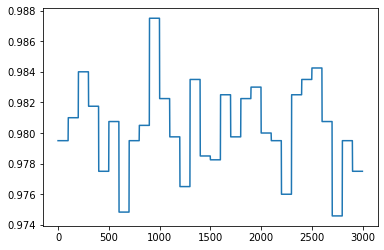

In [ ]:
plt.plot(run.records['valid_acc'])

In [ ]:
save_model(model, trainable_parameters, root + 'model-span-slot-512-12-05.pkl')

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [ ]:
tokenizer, model = get_model('bert-base-uncased', None)
model = add_adapter_layers(model, hidden_size=256)
load_model(model, root + 'model-span-slot.pkl')

_IncompatibleKeys(missing_keys=['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.1.attention.self.query.weight', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.1.attention.self.key.bias', 'bert.encoder.layer.1.attention.self.val

In [ ]:
dataset = D.SlotDataset(root + 'test', tokenizer, max_len=120)
batches = dataset.load_valid_data(128)

In [ ]:
def get_span(strt_index, end_index, input_ids, tokenizer):
    values = []
    for strt, end, ids in zip(strt_index, end_index, input_ids):
        if (strt == 0 and end == 0) or (strt > end):
            span = 'Not mentioned'
        else:
            span = ids[strt:end+1]
            span = ' '.join(tokenizer.convert_ids_to_tokens(span, skip_special_tokens=True))
        values.append(span.replace(' ##', ''))
    return values

def evaluate_valid_data(model, valid_data, tokenizer):
    model.eval()
    with T.no_grad():
        acc, count = 0, 0
        scores, slots, ids = [], [], []
        for i, batch in enumerate(valid_data):
            batch = D.SlotDataset.map_to_cuda(batch)
            _, strt_logits, end_logits  = model(**batch.x)
            metrics = evaluate(strt_logits, end_logits, **batch.x)
            acc_, _, _, _, _, strt_index, end_index = metrics
            acc += (acc_*len(batch.id))
            count += len(batch.id)
            scores += get_span(strt_index, end_index, batch.x['input_ids'].cpu().numpy(), tokenizer)
            slots += batch.slot
            ids += batch.id
            sys.stderr.write(f'\r{i}/{len(valid_data)} acc: {acc_}{"": <30}')
        acc = acc/count
    model.train()
    return {'acc': acc, 'scores': scores, 'labels': slots, 'ids': ids}

In [ ]:
results = evaluate_valid_data(model.cuda(), batches, tokenizer)

292/293 acc: 0.9622641509433962                              

In [ ]:
print(results['acc']) # test

0.9566191772050584


In [ ]:
print(results['acc'])

0.9779947537161178


In [ ]:
print(results['acc'])

0.9746915379384048


In [ ]:
print(results['acc'])

0.9757116486932867


In [ ]:
print(results['acc'])

0.9746915379384048


In [ ]:
print(results['acc'])

0.97221412610512


In [ ]:
print(results['acc'])

0.9747401146410182


In [ ]:
print(results['acc'])

0.9746915379384048


In [ ]:
print(results['acc'])

0.9731370834547751


In [ ]:
print(results['acc'])

0.971836336010419


In [ ]:
print(results['scores'][5])

14th of this month


In [ ]:
import json
with open(root + 'valid-span-value-scores-12-05.json', 'w') as f:
    json.dump(results, f)
#print(acc)

In [ ]:
xx